In this tutorial, we give examples of using MIDI to do the following tasks:

1.Drug response prediction

2.Identify molecular binding atoms

3.Give gene ranking list.

The gene identification embeddings and its corresponding gene names from Geneformer were stored [here](https://github.com/Tingyiwanyan/Gene_embedding_data?tab=readme-ov-file), we provide the sample testing data stored [here](https://github.com/Tingyiwanyan/Michanism_Interpretable_Drug_Gene_Interaction_Modelling/tree/main/sample_data).

Please download the gene embeddings and the gene names first to smoothly run the tutorial code

In [1]:
# Loading necessary packages
from utils.utils import *
from utils.smile_rel_dist_interpreter import *
from base_line_models import *
from drug_transformer import *
import scipy.stats
from sklearn.mixture import BayesianGaussianMixture
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from collections import Counter
#import keras_nlp
from tensorflow.keras import initializers
import json
tf.keras.utils.set_random_seed(812)
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
from random import seed
from random import sample

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.tree import DecisionTreeRegressor
import selfies as sf
import numpy as np
import Geneformer.geneformer as ge
import gseapy as gp
import sys 

2025-03-24 11:46:21.760089: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 11:46:21.817036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 11:46:23.472373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-03-24 11:46:27.621776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27356 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capabi

Load the pretrained model

In [2]:
k = drug_transformer_(gene_embeddings)#, relative_pos_enc_lookup=relative_pos_embedding)
model_midi = k.model_construction_midi(if_mutation=True)
model_midi.load_weights('Pre_train_model/midi_55_epochs_prior_3000_pairs_with_drug_regularizer_softmax_temperature_9_training.h5')
model_midi.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100, 100, 5)]        0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 100, 8)]             0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 100, 100, 60)         360       ['input_5[0][0]']             
                                                                                                  
 dense_0 (Dense)             (None, 100, 60)              540       ['input_1[0][0]']             
                                                                                              

Load the gene embeddings and its corresponding gene names

In [72]:
with open('gene_embedding_important.npy', 'rb') as f:
	gene_embeddings = np.load(f)

gene_name_avail_geneformer = list(np.load('gene_names.npy'))

The model is currently trained on 24 drugs, and we list the drug names below, together with their canonical smile sequences

In [3]:
drug_names = ['17-AAG','NVP-AEW541','AZD0530','AZD6244','Erlotinib','Irinotecan',
 'L-685458','lapatinib','LBW242','nilotinib','nutlin-3','Paclitaxel','Panobinostat',
 'PD-0325901','PD-0332991','Crizotinib','PHA-665752','PLX-4720','RAF265','sorafenib',
 'NVP-TAE684','dovitinib','topotecan','vandetanib']

CCLE_drug_smiles = ['CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C1)C2=O)NCC=C)C)OC)OC(=O)N)C)C)O)OC',
 'C1CN(C1)CC2CC(C2)N3C=C(C4=C(N=CN=C43)N)C5=CC(=CC=C5)OCC6=CC=CC=C6',
 'CN1CCN(CC1)CCOC2=CC3=C(C(=C2)OC4CCOCC4)C(=NC=N3)NC5=C(C=CC6=C5OCO6)Cl',
 'CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=O)NOCCO',
 'COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C)OCCOC',
 'CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=C1C=C(C=C5)OC(=O)N6CCC(CC6)N7CCCCC7',
 'CC(C)CC(C(=O)NC(CC1=CC=CC=C1)C(=O)N)NC(=O)C(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OC(C)(C)C)O',
 'CS(=O)(=O)CCNCC1=CC=C(O1)C2=CC3=C(C=C2)N=CN=C3NC4=CC(=C(C=C4)OCC5=CC(=CC=C5)F)Cl',
 'CC(C(=O)NC(C1CCCCC1)C(=O)N2CCC3C2CN(CC3)CCC4=CC=CC=C4)NC',
 'CC1=C(C=C(C=C1)C(=O)NC2=CC(=CC(=C2)C(F)(F)F)N3C=C(N=C3)C)NC4=NC=CC(=N4)C5=CN=CC=C5',
 'CC(C)OC1=C(C=CC(=C1)OC)C2=NC(C(N2C(=O)N3CCNC(=O)C3)C4=CC=C(C=C4)Cl)C5=CC=C(C=C5)Cl',
 'CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)C(C(C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C',
 'CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO',
 'C1=CC(=C(C=C1I)F)NC2=C(C=CC(=C2F)F)C(=O)NOCC(CO)O',
 'CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCNCC4)C5CCCC5)C(=O)C',
 'CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N=C3)C4CCNCC4)N',
 'CC1=C(NC(=C1C(=O)N2CCCC2CN3CCCC3)C)C=C4C5=C(C=CC(=C5)S(=O)(=O)CC6=C(C=CC=C6Cl)Cl)NC4=O',
 'CCCS(=O)(=O)NC1=C(C(=C(C=C1)F)C(=O)C2=CNC3=C2C=C(C=N3)Cl)F',
 'CN1C2=C(C=C(C=C2)OC3=CC(=NC=C3)C4=NC=C(N4)C(F)(F)F)N=C1NC5=CC=C(C=C5)C(F)(F)F',
 'CNC(=O)C1=NC=CC(=C1)OC2=CC=C(C=C2)NC(=O)NC3=CC(=C(C=C3)Cl)C(F)(F)F',
 'CC(C)S(=O)(=O)C1=CC=CC=C1NC2=NC(=NC=C2Cl)NC3=C(C=C(C=C3)N4CCC(CC4)N5CCN(CC5)C)OC',
 'CN1CCN(CC1)C2=CC3=C(C=C2)N=C(N3)C4=C(C5=C(C=CC=C5F)NC4=O)N',
 'CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=C(C=CC(=C5CN(C)C)O)N=C4C3=C2)O',
 'CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C=C4)Br)F)OC']

In [4]:
"""
create a pandas dataframe mapping drug names to their smile seuqences
"""
df_drug_smile = pd.DataFrame(list(zip(drug_names,CCLE_drug_smiles)),
                             columns=['drug_name','drug_smiles'])
df_drug_smile.set_index('drug_name',inplace =True)

"""
extract self-attention score for drug structure, and cross-attention score
for gene ranking
"""
feature_select_score_model_drug = att_score_self_enco(model_midi,7)
feature_select_score_model_gene = att_score_self_enco(model_midi,31)


#drug_feature_select_score = []
#df_data = pd.read_csv('train_data_midi.csv')
#df_data.set_index("drug_name", inplace=True)

Load the sample test data, for details about the drug response unit, please refer to our paper

In [5]:
continuous_gene_exp = pd.read_csv('continuous_gene_exp.csv')
continuous_gene_exp.rename(columns = {continuous_gene_exp.columns[0]:'cell_line_name'}, inplace=True)
continuous_gene_exp.set_index('cell_line_name', inplace=True)
continuous_gene_exp

,A1BG,A1CF,A2M,A4GALT,AADAC,AADAT,AASS,AATK,ABAT,ABCA1,...,ZNF90,ZNF91,ZNF93,ZNRF3,ZP3,ZRSR2,ZSCAN18,ZSCAN31,ZYG11A,ZYX
cell_line_name,,,,,,,,,,,,,,,,,,,,,
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.368404,0.002772,0.010629,0.062634,0.007218,0.169131,0.154983,0.015523,0.184227,0.047533,...,0.191440,0.224976,0.289899,0.127160,0.079733,0.199935,0.316002,0.325829,0.000000,0.459178
639V_URINARY_TRACT,0.335762,0.000000,0.000961,0.067454,0.000000,0.231685,0.286306,0.020002,0.140481,0.030417,...,0.235221,0.233684,0.263502,0.222958,0.021560,0.234882,0.242556,0.245036,0.110247,0.471828
5637_URINARY_TRACT,0.016286,0.000000,0.009378,0.273977,0.021957,0.297153,0.098459,0.003859,0.026570,0.191191,...,0.174650,0.170738,0.224981,0.184934,0.252308,0.234323,0.195871,0.180635,0.013752,0.494994
22RV1_PROSTATE,0.110484,0.209205,0.128055,0.015317,0.000000,0.203431,0.179409,0.063679,0.100422,0.010487,...,0.021387,0.269506,0.266230,0.184461,0.270705,0.190560,0.107347,0.104400,0.011310,0.278280
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.346611,0.000000,0.014536,0.001833,0.000000,0.000921,0.085569,0.001833,0.117557,0.082961,...,0.271276,0.243197,0.265040,0.117296,0.012939,0.217429,0.334029,0.091957,0.000000,0.305783


In [6]:
mutation_gene = pd.read_csv('continuous_gene_exp.csv')
mutation_gene.rename(columns = {mutation_gene.columns[0]:'cell_line_name'}, inplace=True)
mutation_gene.set_index('cell_line_name', inplace=True)
mutation_gene

,A1BG,A1CF,A2M,A4GALT,AADAC,AADAT,AASS,AATK,ABAT,ABCA1,...,ZNF90,ZNF91,ZNF93,ZNRF3,ZP3,ZRSR2,ZSCAN18,ZSCAN31,ZYG11A,ZYX
cell_line_name,,,,,,,,,,,,,,,,,,,,,
42MGBA_CENTRAL_NERVOUS_SYSTEM,0.368404,0.002772,0.010629,0.062634,0.007218,0.169131,0.154983,0.015523,0.184227,0.047533,...,0.191440,0.224976,0.289899,0.127160,0.079733,0.199935,0.316002,0.325829,0.000000,0.459178
639V_URINARY_TRACT,0.335762,0.000000,0.000961,0.067454,0.000000,0.231685,0.286306,0.020002,0.140481,0.030417,...,0.235221,0.233684,0.263502,0.222958,0.021560,0.234882,0.242556,0.245036,0.110247,0.471828
5637_URINARY_TRACT,0.016286,0.000000,0.009378,0.273977,0.021957,0.297153,0.098459,0.003859,0.026570,0.191191,...,0.174650,0.170738,0.224981,0.184934,0.252308,0.234323,0.195871,0.180635,0.013752,0.494994
22RV1_PROSTATE,0.110484,0.209205,0.128055,0.015317,0.000000,0.203431,0.179409,0.063679,0.100422,0.010487,...,0.021387,0.269506,0.266230,0.184461,0.270705,0.190560,0.107347,0.104400,0.011310,0.278280
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.346611,0.000000,0.014536,0.001833,0.000000,0.000921,0.085569,0.001833,0.117557,0.082961,...,0.271276,0.243197,0.265040,0.117296,0.012939,0.217429,0.334029,0.091957,0.000000,0.305783


In [7]:
df_data = pd.read_csv('df_sample_drug_response_data.csv')
drug_names = list(df_data['drug_name'])
df_data

,Unnamed: 0,drug_name,smile_seq,cell_line_name,drug_response
0,0,17-AAG,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,22RV1_PROSTATE,-3.0622
1,1,NVP-AEW541,C1CN(C1)CC2CC(C2)N3C=C(C4=C(N=CN=C43)N)C5=CC(=...,22RV1_PROSTATE,-1.6723
2,2,AZD0530,CN1CCN(CC1)CCOC2=CC3=C(C(=C2)OC4CCOCC4)C(=NC=N...,22RV1_PROSTATE,-0.6198
3,3,AZD6244,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,22RV1_PROSTATE,-2.8096
4,4,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,22RV1_PROSTATE,-0.2450
...,...,...,...,...,...
95,95,AZD6244,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-2.5412
96,96,Erlotinib,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-1.6441
97,97,Irinotecan,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-5.5188
98,98,L-685458,CC(C)CC(C(=O)NC(CC1=CC=CC=C1)C(=O)N)NC(=O)C(CC...,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,-3.6396


Prepare the data as the input to the model

In [8]:
batch_drug_names = drug_names
batch_smile_seq = list(df_data['smile_seq'])
batch_cell_line_name = list(df_data['cell_line_name'])
batch_drug_response = list(df_data['drug_response'])
drug_atom_one_hot_chunk, drug_rel_position_chunk, edge_type_matrix_chunk,\
drug_smile_length_chunk, gene_expression_bin_chunk, gene_mutation_bin_chunk, gene_prior_chunk = \
extract_input_data_midi(batch_drug_names, batch_smile_seq, \
                        batch_cell_line_name, batch_drug_response, continuous_gene_exp, mutation_gene)

/home2/s222701/anaconda3/envs/envdrug/lib/python3.11/site-packages/tensorflow/python/framework/constant_op.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ops.EagerTensor(value, ctx.device_name, dtype)


Create mask since smile sequence length various between difference drug

In [10]:
batch_shape = drug_atom_one_hot_chunk.shape[0]
mask = tf.range(start=0, limit=100, dtype=tf.float32)
mask = tf.broadcast_to(tf.expand_dims(mask,axis=0),shape=[batch_shape,100])
mask = tf.reshape(mask, shape=(batch_shape*100))
mask = mask < tf.cast(tf.repeat(drug_smile_length_chunk,repeats=100),tf.float32)
mask = tf.where(mask,1,0)
mask = tf.reshape(mask, shape=(batch_shape,100))
mask = tf.expand_dims(mask, axis=-1)

Predict drug response with pre-trained model

In [12]:
prediction, score_cross_global, X_global, Y_gene, \
            Y_gene_embedding, X_global_, att_score_global2, Y_global = \
            model_midi((drug_atom_one_hot_chunk, gene_expression_bin_chunk, \
                        drug_smile_length_chunk, drug_rel_position_chunk, \
                        edge_type_matrix_chunk, gene_mutation_bin_chunk, mask))

Draw the correlation scatter plot to show the drug response prediction accuracy

/tmp/ipykernel_281622/2688178315.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="correlation= %f" %correlation)


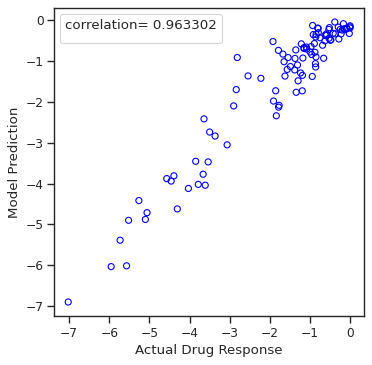

In [42]:
a, b = np.polyfit(np.array(prediction[:,0]),np.array(df_data.drug_response) , 1) 
correlation = scipy.stats.pearsonr(np.array(prediction[:,0]),np.array(df_data.drug_response))[0]
sns.set_style("ticks")
plt.figure(figsize=(5, 5), dpi=80)
plt.scatter(list(np.array(df_data.drug_response)), list(np.array(prediction[:,0])), s=30,marker='o',facecolors='none',color='blue')
plt.legend(title="correlation= %f" %correlation)
plt.ylabel('Model Prediction')
plt.xlabel('Actual Drug Response')
plt.show()

Extract the self-attention score from drug graphformer and cross attention score between drug embeddings and gene identificaiton embeddings

In [57]:
feature_select_score_drug = feature_select_score_model_drug.predict((drug_atom_one_hot_chunk, gene_expression_bin_chunk, \
                                                                    drug_smile_length_chunk, drug_rel_position_chunk, \
                                                                    edge_type_matrix_chunk, gene_mutation_bin_chunk, mask))[1]
feature_select_score_gene = feature_select_score_model_gene.predict((drug_atom_one_hot_chunk, gene_expression_bin_chunk, \
                                                                    drug_smile_length_chunk, drug_rel_position_chunk, \
                                                                    edge_type_matrix_chunk, gene_mutation_bin_chunk, mask))[1][:,0,:]

4/4 [==============================] - 0s 24ms/step


In [63]:
feature_select_score_gene[5]

array([1.06508676e-04, 7.48730818e-05, 3.94747913e-04, ...,
       4.69876744e-04, 1.49127809e-04, 1.03203492e-04], dtype=float32)

In [61]:
len(drug_names)

100

Plot the gene ranking curve for the whole 6144 genes for a specific drug, and the top 20 ranking genes for a zoom in version, we pick a specific drug as an example for illustration

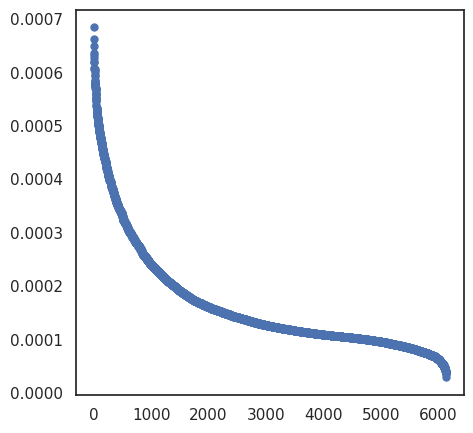

In [75]:
import matplotlib.pyplot as plt
"""
Pick a specific drug as an example, here we pick the 5th drug, and the corresponding 5th cancer cell line with its attention score
gene rankings
"""
drug_name_plot = drug_names[5]

top_genes_score, top_genes_index = tf.math.top_k(feature_select_score_gene[5], k=6144)
top_gene_names = np.array([gene_name_avail_geneformer[j] for j in top_genes_index])

"""
Create a dataframe for the gene ranking list
"""
df_rank_gene = pd.DataFrame(list(zip(list(top_gene_names), list(np.array(top_genes_score)))),
                             columns=['gene_name', 'rank'])

#total_top_gene_rank.set_index('drug_names',inplace=True)
#x = total_top_gene_rank.loc[drug_name_plot]['gene_name']
sns.set_style("white")
x_ = list(range(6144))
y = list(top_genes_score)

plt.figure(figsize=(5,5))
plt.plot(x_,y, 'o',markersize=5)


Plot the top 20 ranking genes for this drug 

Text(0.5, 1.0, 'Irinotecan')

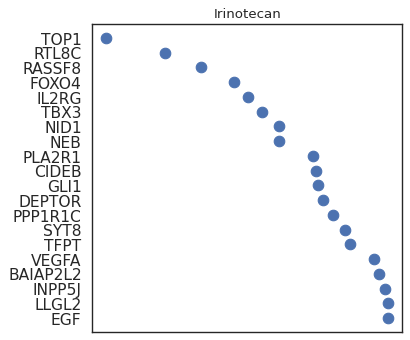

In [82]:
plt.figure(figsize=(5,5),dpi=80)
size = [12*n for n in range(len(top_gene_names))]
plt.scatter(y[0:20],top_gene_names[0:20],s=90)#np.flip(size[0:20])) 
#cmap = plt.get_cmap('Dark2')
sticks = [" " for i in range(20)]
sticks_ = [" " for i in range(20)]
colors = ['red' for i in range(20)]
plt.xticks([])
plt.yticks(fontsize=14)#,fontweight='bold')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.title(drug_name_plot,fontsize=12)

In [106]:
interpret_smile

['C',
 'C',
 'C',
 'C',
 'C',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'O',
 'C',
 'O',
 'C',
 'O',
 'C',
 'C',
 'C',
 'O',
 'C',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'O',
 'C',
 'O',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C']

Plot the self-attention matrix derived from drug graphformer for the specific picked drug

[]

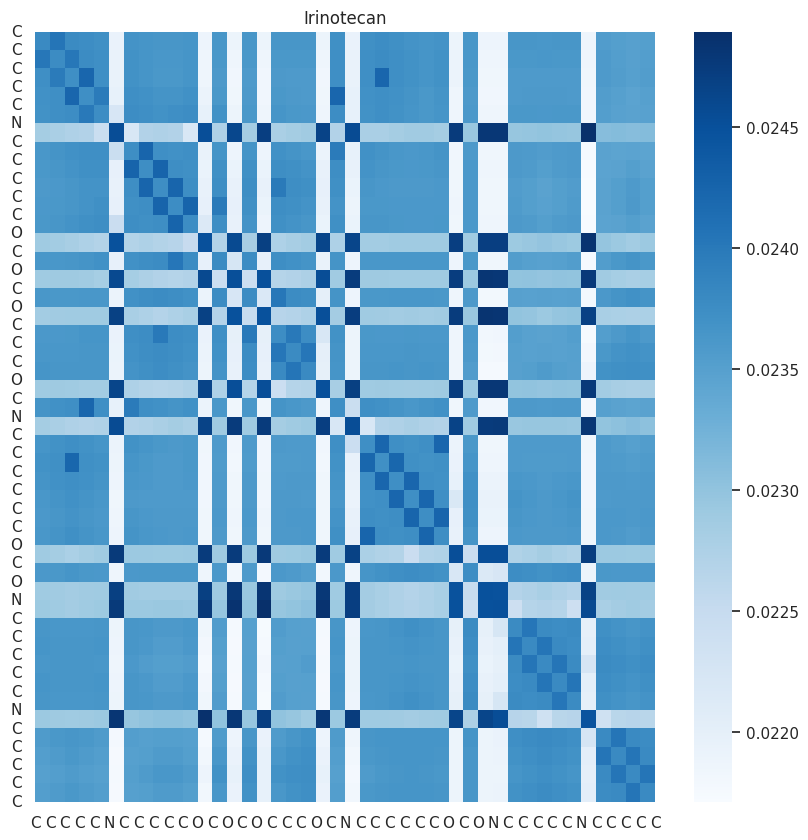

In [108]:
plt.figure()
g = sns.heatmap(feature_select_score_drug[5][0:drug_smile_length_chunk[0],0:drug_smile_length_chunk[0]], cmap="Blues")
sns.set(rc={"figure.figsize":(10,10)})
interpret_smile = list(generate_interpret_smile(batch_smile_seq[5])[0])
x_labels = list(interpret_smile)
y_labels = list(interpret_smile)
#atoms_drug.append(x_labels)
#y_labels.reverse()
g.set_xticks(range(len(x_labels)), labels=x_labels)
#g.set_yticks(range(1), labels=[' '])
g.set_yticks(range(len(y_labels)), labels=y_labels)
g.tick_params(axis='x', rotation=0)
g.set(title =drug_name_plot)
g.plot()

Visualize the highlight atoms selected from top 5 atoms and top 5 bonds in the self-attention drug graphformer matrix

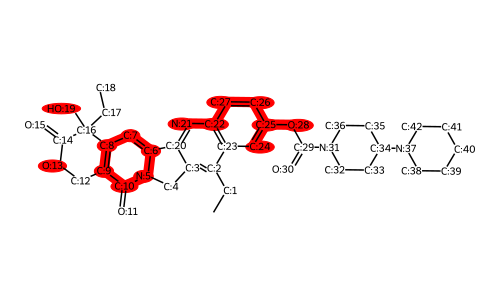

In [104]:
from PIL import Image
from io import BytesIO
weight_atoms_indices, highlight_bond, colors, colors_bond = extract_atoms_bonds(feature_select_score_drug[5], batch_smile_seq[5])
#weight_atoms_indices, highlight_bond, colors, colors_bond = extract_atoms_bonds(feature_select_score_drug_whole[0], batch_smile_seq[0])
mol = Chem.MolFromSmiles(batch_smile_seq[5])
mol = mol_with_atom_index(mol)
d2d = rdMolDraw2D.MolDraw2DCairo(500,300)
option = d2d.drawOptions()
option.legendFontSize = 18
option.bondLineWidth = 1.5
option.highlightBondWidthMultiplier = 20
option.updateAtomPalette({k: (0, 0, 0) for k in DrawingOptions.elemDict.keys()})
d2d.DrawMolecule(mol,highlightAtoms=weight_atoms_indices,highlightAtomColors=colors)#, highlightBonds=highlight_bond, highlightBondColors=colors_bond)
#2d.DrawMolecule(mol,highlightAtoms=weight_atoms_indices, highlightBonds=highlight_bond, highlightBondColors=colors_bond)
#d2d.FinishDrawing()
bio = BytesIO(d2d.GetDrawingText())
Image.open(bio)